# Calling HMETS on the Raven server

Here we use birdy's WPS client to launch the HMETS hydrological model on the server and analyze the output. 

In [1]:
from birdy import WPSClient

from example_data import TESTDATA
import datetime as dt
from urllib.request import urlretrieve
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
import os

# Set environment variable RAVEN_WPS_URL to "http://localhost:9099" to run on the default local server
url = os.environ.get("RAVEN_WPS_URL", "https://pavics.ouranos.ca/twitcher/ows/proxy/raven/wps")
wps = WPSClient(url)

In [2]:
# The model parameters. Can either be a string of comma separated values, a list, an array or a named tuple. 
params = '9.5019, 0.2774, 6.3942, 0.6884, 1.2875, 5.4134, 2.3641, 0.0973, 0.0464, 0.1998, 0.0222, -1.0919, ' \
            '     2.6851, 0.3740, 1.0000, 0.4739, 0.0114, 0.0243, 0.0069, 310.7211, 916.1947'

# Forcing files
ts = TESTDATA['raven-hmets-nc-ts']

# Model configuration parameters
config = dict(
    start_date=dt.datetime(2000, 1, 1),
    end_date=dt.datetime(2002, 1, 1),
    area=4250.6,
    elevation=843.0,
    latitude=54.4848,
    longitude=-123.3659,
    )

# Let's call the model with the timeseries, model parameters and other configuration parameters
resp = wps.raven_hmets(ts=str(ts), params=params, **config)

# And get the response
# With `asobj` set to False, only the reference to the output is returned in the response. 
# Setting `asobj` to True will retrieve the actual files and copy the locally. 
[hydrograph, storage, solution, diagnostics, rv] = resp.get(asobj=True)

Since we requested output objects, we can simply access the output objects. The dianostics is just a CSV file: 

In [3]:
print(diagnostics)

observed data series,filename,DIAG_NASH_SUTCLIFFE,DIAG_RMSE,
HYDROGRAPH,/tmp/pywps_process_zan0_otk/input.nc,-7.03141,101.745,



The `hydrograph` and `storage` outputs are netCDF files storing the time series. These files are opened by default using `xarray`, which provides convenient and powerful time series analysis and plotting tools. 

In [4]:
hydrograph.q_sim

<xarray.DataArray 'q_sim' (time: 732, nbasins: 1)>
array([[  0.      ],
       [170.910938],
       [338.27671 ],
       ...,
       [ 39.27025 ],
       [ 38.468564],
       [ 37.723351]])
Coordinates:
  * time        (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2002-01-01
    basin_name  (nbasins) object ...
Dimensions without coordinates: nbasins
Attributes:
    units:      m**3 s**-1
    long_name:  Simulated outflows

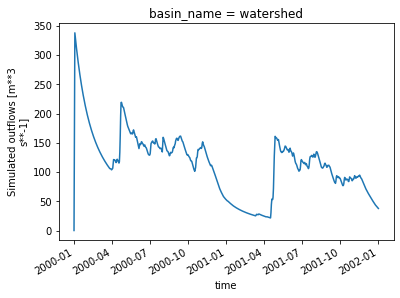

In [5]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

hydrograph.q_sim.plot()

In [6]:
print("Max: ", hydrograph.q_sim.max())
print("Mean: ", hydrograph.q_sim.mean())
print("Monthly means: ", hydrograph.q_sim.groupby(hydrograph.time.dt.month).mean(dim='time'))

Max:  <xarray.DataArray 'q_sim' ()>
array(338.27670973)
Mean:  <xarray.DataArray 'q_sim' ()>
array(114.21520508)
Monthly means:  <xarray.DataArray 'q_sim' (month: 12, nbasins: 1)>
array([[145.47625261],
       [100.23013979],
       [ 72.54535855],
       [100.5531725 ],
       [158.08129744],
       [131.89812816],
       [132.25412379],
       [129.30157554],
       [122.49175427],
       [104.23439113],
       [108.01578307],
       [ 64.06515605]])
Coordinates:
    basin_name  (nbasins) object ...
  * month       (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: nbasins
